# Kanazawa U. lab. CMOS event data QL example

In [19]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
import astropy.io.fits as pyfits

plt.rcParams["font.family"]="serif"
plt.rcParams["font.size"]= 10

In [20]:
evtfname = '24-0613-2003-31.evt'
#evtfname = '24-0613-1948-44.evt'
#evtfname = '24-0612-1715-49.evt'
#evtfname = "24-0612-1658-27.evt"
#evtfname = 'test.evt'


hdul = pyfits.open(evtfname)
hdu = hdul["EVENTS"]

vtime = hdu.data.field("TIME")
vx = hdu.data.field("X")
vy = hdu.data.field("Y")
vadu = hdu.data.field("ADU")
vflag = hdu.data.field("FLAG")
vframeid = hdu.data.field("FRAMEID")

### read header keyword
print("TELESCOP = ", hdu.header["TELESCOP"])
print("INSTRUME = ", hdu.header["INSTRUME"])
print("TIMEDEL  = ", hdu.header["TIMEDEL"])

timedel = hdu.header["TIMEDEL"]
xpixmin = hdu.header["TLMIN2"]
xpixmax = hdu.header["TLMAX2"]
ypixmin = hdu.header["TLMIN3"]
ypixmax = hdu.header["TLMAX3"]
adumin = hdu.header["TLMIN4"]
adumax = hdu.header["TLMAX4"]

print("TIMEDEL =", timedel)
print("Xmin, Xmax = ", xpixmin, xpixmax)
print("Ymin, Ymax = ", ypixmin, ypixmax)
print("ADUmin, ADUmax = ", adumin, adumax)

hdul.close()

TELESCOP =  HIZGUNDAM
INSTRUME =  WXM
TIMEDEL  =  0.1
TIMEDEL = 0.1
Xmin, Xmax =  0 1023
Ymin, Ymax =  0 1023
ADUmin, ADUmax =  0 4095


Text(0.5, 1.0, 'Event count rate')

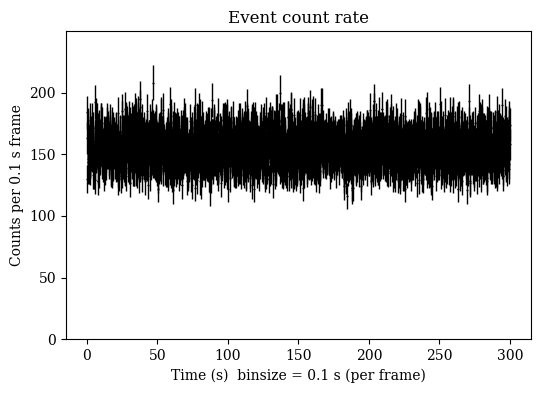

In [21]:
### Event counts per frame ####
fig1, ax1 = plt.subplots(figsize=(6,4))

tmin = vtime[0]
tmax = vtime[-1]
nbin = int((tmax - tmin)/timedel)+1
xmi = tmin - 0.5*timedel
xma = tmax + 0.5*timedel
#print("nbin = %d,  xmi, xma = %.2lf, %.2lf"%(nbin, xmi, xma))

hist_frmcts, xedges   = np.histogram(vtime, nbin, range=(xmi, xma))
vxcen = (xedges[:-1] + xedges[1:])/2.
vxwid = (xedges[1:] - xedges[:-1])/2.
hister_frmcts = np.sqrt(hist_frmcts)
ax1.errorbar(vxcen, hist_frmcts, xerr=vxwid, yerr=hister_frmcts, fmt='.', ms=1, lw=1, color='k')
ymax = hist_frmcts.max()*1.2
ax1.set_ylim(0.0, ymax)

ax1.set_xlabel('Time (s)  binsize = 0.1 s (per frame)')
ax1.set_ylabel('Counts per 0.1 s frame')
ax1.set_title('Event count rate')

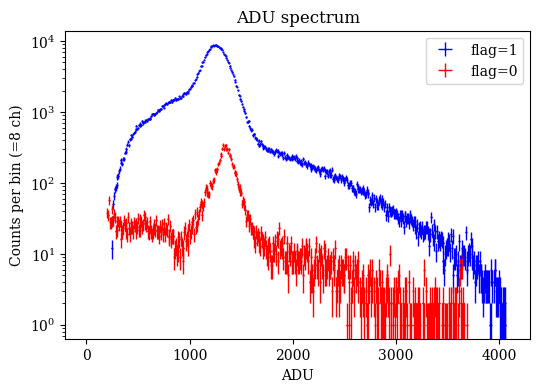

In [22]:
### ADU specturm
fig2, ax2 = plt.subplots(figsize=(6,4))
binsize = 8
#nbin = int(4096/binsize)
#xmi = -0.5
#xma = 4096-0.5
nbin = int((adumax-adumin+1)/binsize)
xmi = adumin-0.5
xma = adumax+0.5

hist_adu1, xedges = np.histogram(vadu[vflag==1], nbin, range=(xmi, xma))
hist_adu2, xedges = np.histogram(vadu[vflag==0], nbin, range=(xmi, xma))
vxcen = (xedges[:-1] + xedges[1:])/2.
vxwid = (xedges[1:] - xedges[:-1])/2.
hister_adu1 = np.sqrt(hist_adu1)
hister_adu2 = np.sqrt(hist_adu2) 
ax2.errorbar(vxcen, hist_adu1, xerr=vxwid, yerr=hister_adu1, fmt='.', ms=1, lw=1, color='b', label='flag=1')
ax2.errorbar(vxcen, hist_adu2, xerr=vxwid, yerr=hister_adu2, fmt='.', ms=1, lw=1, color='r', label='flag=0')
ax2.set_xlabel('ADU')
ax2.set_ylabel('Counts per bin (=%d ch)'%(binsize))
ax2.set_title('ADU spectrum')     
ax2.set_yscale('log')
ax2.legend()

Text(0.5, 0.95, 'Image (log scale)')

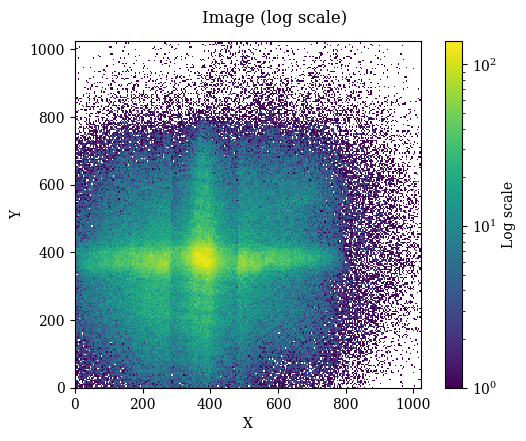

In [23]:
###  XY image (log scale) 
#nx = 1024
#ny = 1024
#xmima = [-0.5, nx-0.5]
#ymima = [-0.5, ny-0.5]
nxpix = xpixmax-xpixmin+1
nypix = ypixmax-ypixmin+1
xmima = (xpixmin-0.5, xpixmax+0.5)
ymima = (ypixmin-0.5, ypixmax+0.5)

#binsize = 2
binsize = 4
nbinx = int(nxpix/binsize)
nbiny = int(nypix/binsize)

hist2d, xedges, yedges = np.histogram2d(vx, vy, bins=(nbinx, nbiny), range=(xmima, ymima))
fig3, ax3 = plt.subplots(figsize=(6, 4.5))
hist2d = hist2d.T
im = ax3.imshow(hist2d, interpolation='nearest', origin='lower',
                norm=colors.LogNorm(),
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

ax3.set_xlabel("X")
ax3.set_ylabel("Y")
cb3 = fig3.colorbar(im, ax=ax3, label='Log scale') 
fig3.suptitle('Image (log scale)', y=0.95)

Text(1.05, -1.8, 'Linear scale')

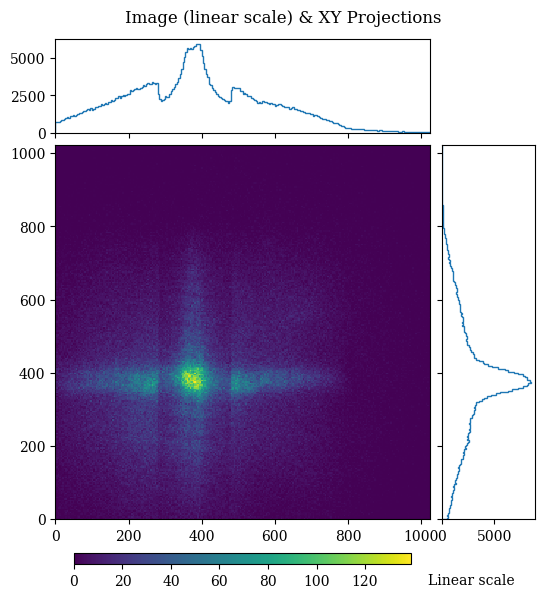

In [24]:
###  XY image and Projections
fig4 = plt.figure(figsize=(6,6)) # , layout="constrained")
gs = fig4.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                       left=0.12, right=0.92, bottom=0.12, top=0.92,
                       wspace=0.05, hspace=0.05)

ax4 = fig4.add_subplot(gs[1, 0])
ax4_histx = fig4.add_subplot(gs[0, 0], sharex=ax4)
ax4_histy = fig4.add_subplot(gs[1, 1], sharey=ax4)
ax4_histx.tick_params(axis="x", labelbottom=False)
ax4_histy.tick_params(axis="y", labelleft=False)

im2 = ax4.imshow(hist2d, interpolation='nearest', origin='lower',
                 #norm=colors.LogNorm(),
                 extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

ax4_histx.hist(vx, xedges, histtype='step') 
ax4_histy.hist(vy, xedges, histtype='step', orientation='horizontal') 

fig4.suptitle('Image (linear scale) & XY Projections', y=0.97)
cax4 = ax4.inset_axes([0.05, -0.12, 0.9, 0.03])
cb4 = fig4.colorbar(im2, cax=cax4, orientation='horizontal')
cax4.text(1.05, -1.8, "Linear scale", transform=cax4.transAxes)